## Cooperative Multi-Agent Reinforcement Learning (CoMARL): with Communication (A2C as base)

合作关系多智能体，有通信，基于A2C

因为有通信,所以所有actor的视野是共享的,它们的state相同.

因为是合作任务,reward也相同.

因为有通信,所以只需要一个critic.

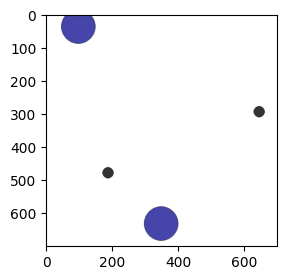

In [3]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    from pettingzoo.mpe import simple_spread_v3
    self.N = 2
    env = simple_spread_v3.env( N=self.N,
                                local_ratio=0.5,
                                max_cycles=1e8,
                                render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    self.env.reset()
    self.step_n = 0
    
    # 不允许两个目标靠的太近
    import numpy as np
    mark0, mark1 = self.env.env.env.world.landmarks
    dist = np.array(mark0.state.p_pos) - np.array(mark1.state.p_pos)
    dist = (dist ** 2).sum() ** 0.5
    if dist < 1:
      return self.reset()
    
    return self.state()
  
  def state(self):
    state = []
    for i in self.env.agents:
      state.append(env.observe(i).tolist())
    return state
  
  def step(self, action):
    #走一步停N步,取消惯性.
    reward_sum = [0] * self.N
    for i in range(5):
      if i != 0:
        action = [-1, -1]
      next_state, reward, over = self._step(action)
      for j in range(self.N):
        reward_sum[j] += reward[j]
      self.step_n -= 1
    
    self.step_n += 1

    return next_state, reward_sum, over
  
  def _step(self, action):
    for i, _ in enumerate(env.agent_iter(self.N)):
      self.env.step(action[i] + 1)
    
    reward = [self.env.rewards[i] for i in self.env.agents]
    
    _, _, termination, truncation, _ = env.last()
    over = termination or truncation
    
    # 限制最大步数
    self.step_n += 1
    if self.step_n >= 50:
      over = True
      
    return self.state(), reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()
env.reset()

env.show()

In [9]:
import torch
	

class A2C: 
  
  def __init__(self, model_actor, model_critic, model_critic_delay, optimizer_actor, optimizer_critic):
    self.model_actor = model_actor
    self.model_critic = model_critic
    self.model_critic_delay = model_critic_delay
    self.optimizer_actor = optimizer_actor
    self.optimizer_critic = optimizer_critic
    
    self.model_critic_delay.load_state_dict(self.model_critic.state_dict())
    self.requires_grad(self.model_critic_delay, False)
    
  def soft_update(self, _from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
      value = _to.data * 0.99 + _from.data * 0.01
      _to.data.copy_(value)
      
  def requires_grad(self, model, value):
    for param in model.parameters():
      param.requires_grad_(value)
      
  def train_critic(self, state, reward, next_state, over):
    self.requires_grad(self.model_actor, False)
    self.requires_grad(self.model_critic, True)
    
    # 计算values和targets
    value = self.model_critic(state)
    
    with torch.no_grad():
      target = self.model_critic_delay(next_state)
    target = target * 0.99 * (1 - over) + reward
    
    # 时序差分： tdloss
    loss = torch.nn.functional.mse_loss(value, target)
    
    loss.backward()
    self.optimizer_critic.step()
    self.optimizer_critic.zero_grad()
    self.soft_update(self.model_critic, self.model_critic_delay)
    
    # 去基线
    return (target - value).detach() # code change here
  
  # 训练actor
  def train_actor(self, state, action, value):
    self.requires_grad(self.model_actor, True)
    self.requires_grad(self.model_critic, False)
    
    # 重新计算动作概率
    prob = self.model_actor(state)
    prob = prob.gather(dim=1, index=action)
    
    # 根据策略梯度算法发的导函数
    # 函数中的Q(state, action), 用critic模型估计
    prob = (prob + 1e-8).log() * value
    loss = -prob.mean()
    
    loss.backward()
    self.optimizer_actor.step()
    self.optimizer_actor.zero_grad()
    
    return loss.item()
  

# 演员模型：计算动作概率
model_actor = [
  torch.nn.Sequential(
    torch.nn.Linear(6 * env.N * env.N, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(dim=1),
  ) for _ in range(env.N)
]


# 评委模型：计算每个动作价值
model_critic, model_critic_delay = [
  torch.nn.Sequential(
    torch.nn.Linear(6 * env.N * env.N, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
  ) for _ in range(2)
]

optimizer_actor = [
  torch.optim.Adam(model_actor[i].parameters(), lr=1e-3)
  for i in range(env.N)
]

optimizer_critic = torch.optim.Adam(model_critic.parameters(), lr=5e-3)

a2c = [
  A2C(model_actor[i], model_critic, model_critic_delay, optimizer_actor[i], optimizer_critic)
  for i in range(env.N)
]

model_actor = None
model_critic = None
model_critic_delay = None
optimizer_actor = None
optimizer_critic = None

a2c

[<__main__.A2C at 0x13c8428e430>, <__main__.A2C at 0x13c8428e490>]

In [10]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  state = []
  action = []
  reward = []
  next_state = []
  over = []

  s = env.reset()
  o = False
  while not o:
    a = []
    for i in range(env.N):
      prob = a2c[i].model_actor(torch.FloatTensor(s).reshape(1, -1))[0].tolist()
      a.append(random.choices(range(4), weights=prob, k=1)[0])
		
    # 执行动作
    ns, r, o = env.step(a)

    state.append(s)
    action.append(a)
    reward.append(r)
    next_state.append(ns)
    over.append(o)
  
    s = ns

    if show:
      display.clear_output(wait=True)
      env.show()
  
  state = torch.FloatTensor(state)
  action = torch.LongTensor(action).unsqueeze(-1)
  reward = torch.FloatTensor(reward).unsqueeze(-1)
  next_state = torch.FloatTensor(next_state)
  over = torch.LongTensor(over).reshape(-1, 1)

  return state, action, reward, next_state, over, reward.sum().item()

state, action, reward, next_state, over, reward_sum = play()

reward_sum

-681.89111328125

In [11]:
#训练
def train():
  
  # 共训练N轮
  for epoch in range(5_0000):
    state, action, reward, next_state, over, _ = play()
  
    # 合并部分字段
    state_c = state.flatten(start_dim=1)
    reward_c = reward.sum(dim=1)
    next_state_c = next_state.flatten(start_dim=1)
    
    for i in range(env.N):
      value = a2c[i].train_critic(state_c, reward_c, next_state_c, over)
      loss = a2c[i].train_actor(state_c, action[:, i], value)
      
    if epoch % 2500 == 0:
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, loss, test_result)

train()

0 -17.047199249267578 -518.6991470336914
2500 -1.0599608421325684 -117.9530569076538
5000 -0.20614874362945557 -106.17165946960449
7500 -0.8119373321533203 -92.87043342590331
10000 -0.23055732250213623 -98.84178161621094
12500 -0.45151278376579285 -91.77775421142579
15000 -0.19517482817173004 -78.35025138854981
17500 -0.10582829266786575 -90.59468498229981
20000 0.03864236921072006 -77.09019298553467
22500 -0.11871017515659332 -79.12784481048584
25000 -0.1969737559556961 -99.85749435424805
27500 0.016669631004333496 -80.75861320495605
30000 0.11210304498672485 -98.75417366027833
32500 -0.027483027428388596 -115.31276168823243
35000 -0.31776735186576843 -93.67578773498535
37500 -0.1422111690044403 -100.85827026367187
40000 0.021500006318092346 -118.06718406677246
42500 -0.101386159658432 -131.25066089630127
45000 -8.204352525353897e-06 -133.54058113098145
47500 -0.522510290145874 -102.39903392791749


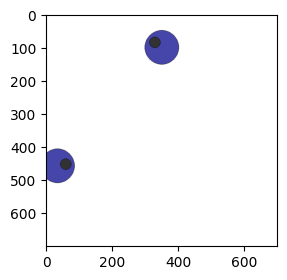

-59.93574142456055

In [13]:
play(True)[-1]